# Regresión logística

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes()
from plot_post import plot_post
import pandas as pd  # importar pandas

Antes de pasar a hablar de la regresión logística, vamos a tomar un pequeño desvío para hablar un poco de la terminología usada en _Machine Learning_ el objetivo es simplemente establecer algunos paralelos entre lo que hemos visto (y seguiremos viendo) de estadística Bayesiana y _Machine learning_. Después de todo hay mucho en común entre ambas metodologías.

En _Machine Learning_ se suelen dividir los algoritmos en dos grandes grupos

* Aprendizaje supervisado: Basicamente en este caso queremos aprender la relación entre una variable predictora $x$ y una predicha $y$. Para ello contamos con pares ($x, y$). En cierto sentido en este tipo de problemas sabemos la repuesta correcta (en términos de salida-entrada), pero queremos encontrar un modelo que relacione ambas variables y que además sea generalizable. Es decir que el modelo sirva para predecir valores no observados de $y$ para valores valores aun no observados de $x$. Dentro de ese grupo encontramos a la:
    * Regresión: la variable predicha toma valores continuos (es métrica).
    * Clasificación: la variable predicha es categórica.
    
* Aprendisaje no supervisado: En este caso solo tenemos la varible x, es decir no sabemos la respuesta correcta en el sentido de no tener los pares ($x, y$), por lo que el objetivo aquí se lo suele definir como _encontrar patrones interesantes_ (como verán un objetivo bastante mas vago que el anterior). Dentro de ese grupo encontramos al:
    * _Clustering_ (agrupamiento): El objetivo es asignar los datos a grupos de acuerdo a características similares (Algunos métodos requieren la cantidad de grupos como argumento)
    * Reducción de dimensionalidad: El objetivo es encontrar una nueva representación de los datos que requiera un menor número de dimensiones. Esto es posible por un lado por que se está dispuesto a perder información en el proceso y por el otro por que efectivamente muchos conjuntos de datos reales tienen una _dimensionalidad aparente_ mayor que la _dimensionalidad real_.

Volviendo a la regresión logística, como su nombre lo indica la regresión logística, es un método de clasificación! Si, en realidad este método se usa para clasificar. El nombre "regresión" se debe a que internamente usamos una regresión como las que estuvimos viendo en capítulos anteriores. Si bien hasta ahora no lo habiamos obviado es posible escribir un modelo linearl generalizado de la siguiente forma :

$$\mu = f(\alpha + \beta X)$$

donde $f$ es lo que se conoce como función de enlace. En todos los casos vistos hasta ahora $f$ fue la funcion identidad, es decir la función que cumple con la siguiente condición $f(\mu) = \mu$ (ya lo sé, no parece una función muy útil, pero facilita el generalizar ideas). Pero podemos usar cualquier función que nos sea útil, una de ellas es la función logística:

$$ logistica(z) = \frac{1}{1 + \exp(-z)}$$

No importa el rango de $z$ el resultado de esta función siempre estará entre 0 y 1:

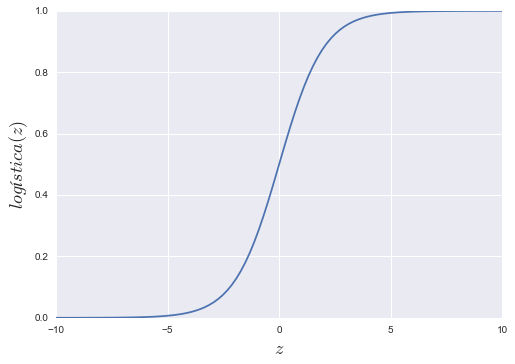

In [2]:
z = np.linspace(-10, 10, 100)
logistic = 1 / (1 + np.exp(-z))
plt.plot(z, logistic)
plt.xlabel('$z$', fontsize=18)
plt.ylabel('$logística(z)$', fontsize=18);

Esta propiedad de la función logística de _comprimir_ valores de $\mu$ de $[-\infty, \infty]$ a $[0, 1]$ permite que asignemos una probabilidad a un a respuesta binaria (enfermo/sano, spam/ham, etc). Además podemos crear un _limite de decisión_ por ejemplo si el resultado está por encima de 0.5 asignamos la observación a la categoría 1 y si está por debajo a la categoria 0 y _voilà!_ tenemos nuestro método de clasificación (al menos para dos categorías).

Un método similar a la regresión logística es la regresion _probit_ que en vez de usar la funcion logística usa la función _probit_!  que no es más que la inversa de la función de distribución acumulada de la distribución normal estándard.

Entonces el modelo bayesiano para la regresión logística es:

$$\mu = logistic(\alpha + \beta X)$$
$$y \sim Bern(\mu)$$

Ahora los datos no se distribuyen como una distribucion gaussiana, si no que lo hace segun una distribución Bernoulli, ya que solo puede tomar dos estados 0 o 1. 

Como _a prioris_ podríamos usar:

$$\alpha \sim \mathcal{N}(\mu_{\alpha}, \sigma_{\alpha})$$
$$\beta \sim \mathcal{N}(\mu_{\beta}, \sigma_{\beta}) $$

gráficamente tenemos:

<img alt="regresión_logística" src="imagenes/logística.png", width=250>

Como siempre vamos a necesitar datos. Esta vez usaremos el super-clásico conjunto de datos iris. En este conjunto se describen tres especies de plantas del género _iris_ (_setosa_, _virginica_, _versicolor_) a las que se les ha medido 4 características de sus flores, el largo y ancho del sépalo y el ancho y largo del pétalo. Ahora veamos si es posible usar estas carácterísticas para distinguir entre estas especies.

In [3]:
iris = sns.load_dataset("iris")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


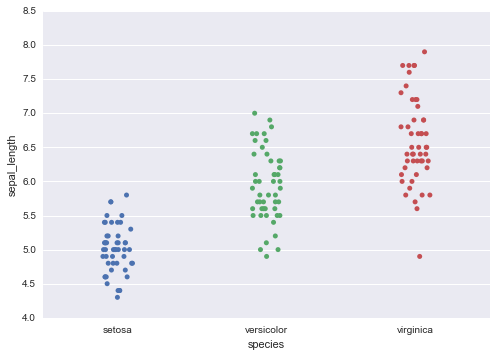

In [4]:
sns.stripplot(x="species", y="sepal_length", data=iris, jitter=True);

/home/osvaldo/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


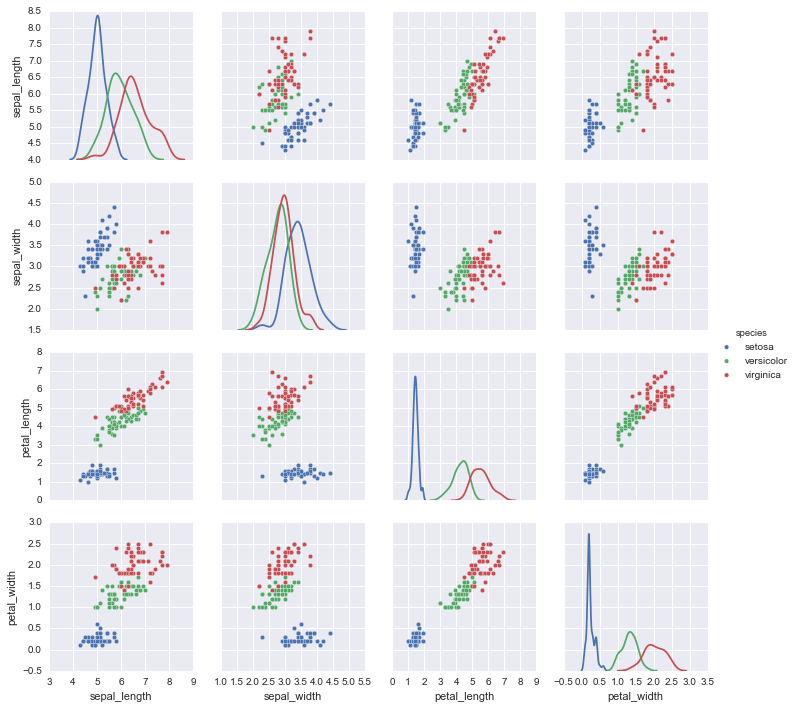

In [5]:
sns.pairplot(iris, hue='species', diag_kind='kde');

In [6]:
df = iris[(iris['species'] == 'setosa') | (iris['species'] == 'versicolor')]
y_0 = pd.Categorical(df['species']).labels
x_n = 'sepal_length' 
x_0 = df[x_n].values

La implementación en PyMC3 de este modelo no contiene ningun elemento que no hayamos visto antes. A los fines prácticos de luego analizar el resultado de la inferencia hemos definido dos variables deterministas _p_ y _ld_, _p_ es parte del modelo descripto más arriba (pero podríamos haber optado por escribirla sin la función _Deterministic()_) y _ld_ no figura en el modelo pero es simplemente $-\frac{\alpha}{\beta}$ y representa el _límite de decisión_ el cual separa ambas clases, es el valor de $x$ cuando $y=0.5$. ¿De donde sale este valor? 

$$\mu = logistic(\alpha + \beta x)$$

$$\mu = 0.5 \Rightarrow \alpha + \beta x=0$$

Reordenando encontramos que el valor de $x$ para el cual se cumple que $y=0.5$ es:

$$x = -\frac{\alpha}{\beta}$$

Como sucede con otros modelos lineales generalizados estandarizar los datos aumenta la eficiencia del muestreo (ya sea que usemos Metropolis() o NUTS()). Para este ejemplo dejaremos los datos sin modificar.

In [7]:
with pm.Model() as modelo_0:
    # definimos los a prioris
    alfa = pm.Normal('alfa', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)
    
    mu = alfa + pm.dot(x_0, beta)
    p = pm.Deterministic('p', 1 / (1 + pm.exp(-mu)))
    
    ld = pm.Deterministic('ld', -alfa/beta)
    
    # definimos el likelihood
    yl = pm.Bernoulli('yl', p=p, observed=y_0)
    # Muestreamos
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_0 = pm.sample(5000, step, start)

 [-----------------100%-----------------] 5000 of 5000 complete in 18.5 sec

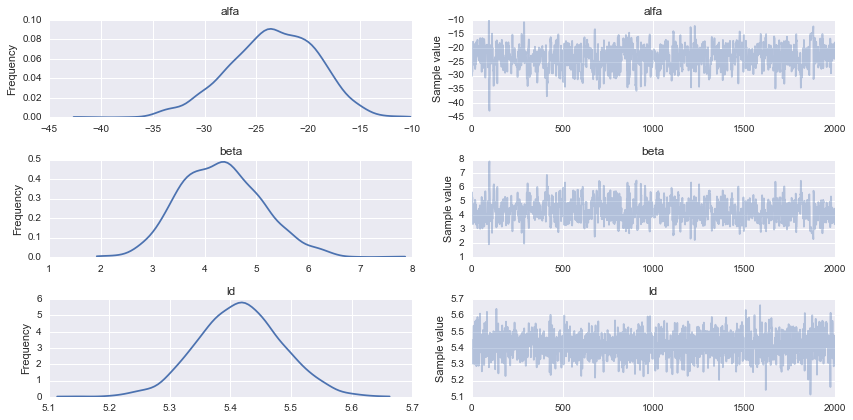

In [8]:
cadena_0 = trace_0[1000::2]
varnames = ['alfa', 'beta', 'ld']
pm.traceplot(cadena_0, varnames);

In [9]:
#pm.autocorrplot(cadena_0, varnames);

In [10]:
#sns.kdeplot(cadena_0['alfa'], cadena_0['beta']);

In [11]:
pm.df_summary(cadena_0, varnames)

/home/osvaldo/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


,mean,sd,mc_error,hpd_2.5,hpd_97.5
alfa,-23.376290,4.253448,0.178156,-31.114191,-14.973870
beta,4.317471,0.788799,0.033076,2.817448,5.817283
ld,5.415534,0.069903,0.001754,5.289139,5.558815


La siguiente figura muestra el ancho del sépalo vs el tipo de flor (setosa = 0, versicolor=1). Con una linea azul hemos graficado la curva sigmoide promedio según el _a posteriori_ recordemos que esta curva puede ser interpretada como la probabilidad de que un punto con $x$ largo de sépalo tenga una probabilidad $p$ de pertenecer a la clase 1 (versicolor en nuestro caso). La franja azul semitransparente es le $HDI_{95}$ para $p$. Además tenemos la linea roja que representa el límite de decisión promedio y su $HDI_{95}$ (la franja roja semitransparente). Según el _ld_ los valores a la derecha corresponden a la clase 1 y los valores a la izquierda a la clase 0. 

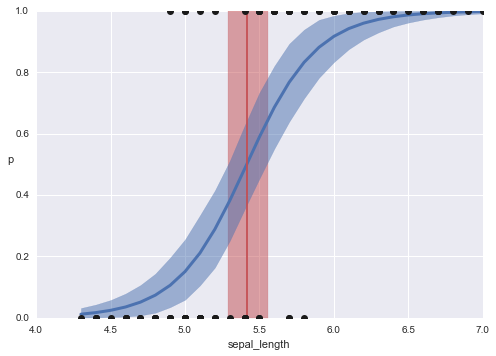

In [12]:
p = cadena_0['p'].mean(axis=0)
idx = np.argsort(x_0)
plt.plot(x_0[idx], p[idx], color='b', lw=3);
plt.axvline(cadena_0['ld'].mean(), ymax=1, color='r')
ld_hpd = pm.hpd(cadena_0['ld'])
plt.fill_betweenx([0, 1], ld_hpd[0], ld_hpd[1], color='r', alpha=0.5)

plt.plot(x_0, y_0, 'o', color='k')
p_hpd = pm.hpd(cadena_0['p'])[idx]
plt.fill_between(x_0[idx], p_hpd[:,0], p_hpd[:,1], color='b', alpha=0.5)

plt.xlabel(x_n)
plt.ylabel('p', rotation=0);

Queda claro que el modelo anterior no es capaz de separar de forma perfecta ambas clases, pero esto es totalmente razonable dado que, según los datos, versicolor puede tener valores tan cortos del largo de sépalo como ~4,9 y setosa tan largos como ~5.8. Es decir hay un rango de valores que va desde ~4.9 hasta ~5.8 que puede ser compartido por ambas especies. ¿cual sería el resultado si usáramos alguna de las otras 3 variables?

Una vez obtenidos los parámetros podemos generar una función como la que se esboza más abajo que dado un valor de una variable (por ejemplo el largo del sépalo) obtengamos la probabilidad que la flor pertenezca a la clase versicolor (respecto de pertenecer a la clase setosa)

In [13]:
def clasifique(n):
    """
    Una función simple para clasificar
    """
    n = np.array(n)
    mu = cadena_0['alfa'].mean() + cadena_0['beta'].mean() * n
    prob = 1 / (1 + np.exp(-mu))
    return prob 

clasifique([5, 5.5, 6])

array([ 0.14320339,  0.59141085,  0.92611827])

## Regresión logística múltiple

Ahora veamos que sucede si usamos dos predictores, por ejemplo el ancho y largo del sépalo.

In [14]:
df = iris[(iris['species'] == 'setosa') | (iris['species'] == 'versicolor')]
y_1 = pd.Categorical(df['species']).labels
x_n = ['sepal_length', 'sepal_width']# 'petal_length', 'petal_width'
x_1 = df[x_n].values

#x_1 = (x_1 - x_1.mean(axis=0))/x_1.std(axis=0) #

El modelo es igual al anterior solo que ahora tenemos dos variables y por lo tanto ahora tendremos dos coeficientes $\beta$  

Siguiendo la misma lógica que en el caso anterior podemos determinar cual es _límite de decisión_:

$$\mu = logistic(\alpha + \beta_0 x_0 + \beta_1 x_1)$$

$$\mu = 0.5 \Rightarrow \alpha + \beta_0 x_0 + \beta_1 x_1=0$$

Reordenando encontramos que el valor de $x_1$ para el cual se cumple que $y=0.5$ es:

$$x_1 = \frac{-\alpha}{\beta_1} + \frac{-\beta_0}{\beta_1} x_0$$

Esta expresión tiene la forma de la ecuación de una recta, por lo que el límite de decision en dos dimensiones es una linea recta.

In [15]:
with pm.Model() as modelo_1:
    # definimos los a prioris
    alfa = pm.Normal('alfa', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=len(x_n))
    
    mu = alfa + pm.dot(x_1, beta)
    # hacemos la transformación logística
    p = 1 / (1 + pm.exp(-mu))
    # calculamos el límite de decisión
    ld = pm.Deterministic('ld', -alfa/beta[1] - beta[0]/beta[1] * x_1[:,0])
    
    # definimos el likelihood
    yl = pm.Bernoulli('yl', p=p, observed=y_1)
    # Muestreamos
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_1 = pm.sample(5000, step, start)

 [-----------------100%-----------------] 5000 of 5000 complete in 21.6 sec

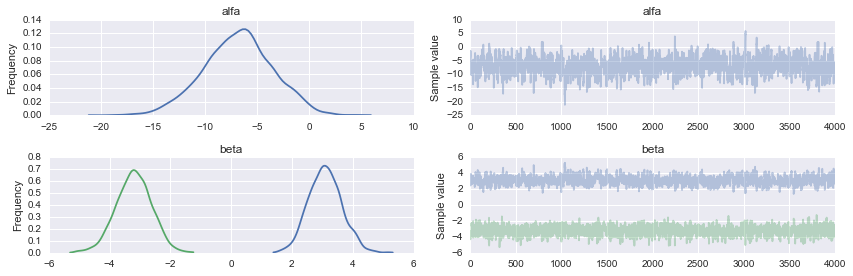

In [16]:
cadena_1 = trace_1[1000::]
varnames = ['alfa', 'beta']
pm.traceplot(cadena_1, varnames);

In [17]:
pm.df_summary(cadena_1, varnames)

/home/osvaldo/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


,mean,sd,mc_error,hpd_2.5,hpd_97.5
alfa,-6.830234,3.319601,0.123020,-13.271048,-0.308868
beta__0,3.095032,0.549084,0.020404,2.104919,4.231440
beta__1,-3.203721,0.587901,0.015630,-4.387018,-2.104896


El siguiente gráfico es similar al que hicimos para un solo predictor, con la diferencia que ahora no hemos dibujado la curva sigmoidea (que ahora no es una linea si no una superficie, por lo que sería necesario un gráfico 3D), solo hemos dibujado el límite de decisión.

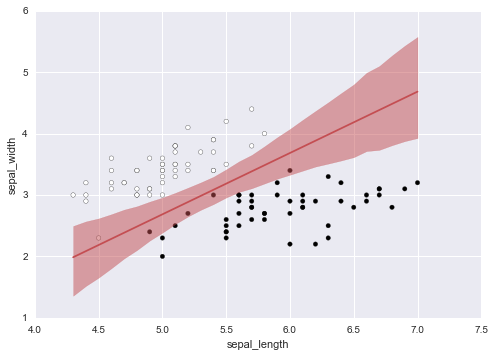

In [18]:
idx = np.argsort(x_1[:,0])
ld = cadena_1['ld'].mean(0)[idx]
plt.scatter(x_1[:,0], x_1[:,1], c=y_0)
plt.plot(x_1[:,0][idx], ld, color='r');

ld_hpd = pm.hpd(cadena_1['ld'])[idx]
plt.fill_between(x_1[:,0][idx], ld_hpd[:,0], ld_hpd[:,1], color='r', alpha=0.5);

plt.xlabel(x_n[0])
plt.ylabel(x_n[1]);

## Variables correlacionadas

Qué pasaría si usáramos otras variables como por ejemplo el ancho y el largo del pétalo.

Si hicieron el ejercicio anterior verán que el resultado luce algo extraño sobre todo para $ld$. A simple vista el problema de separar setosa y versicolor usando el ancho y el largo del pétalo parece un problema muy simple sin embargo la incertidumbre es grande. Esto puede sonar contraintuitivo, pero no tiene nada de raro (y de hecho ya vimos este problema antes).

Resulta que tenemos variables con correlaciones altas, como se puede ver en el siguiente _heatmap_, y eso como ya vimos puede traer problemas simplemente por que existen muchas combinaciones de los coeficientes que satisfacen las restricciones impuestas por los datos (o a la inversa los datos no restringen demasiado a los coeficientes). Es decir según nuestro modelo existen un gran numero de posibles soluciones para separar estos grupo y el _a posteriori_ simplemente refleja esto. Una posible solución es no usar variables _altamente_ correlacionadas, la otra usar _a priori_ que _regularice_ la inferencia. ¿Que sucede al modificar la desviación estádard del _a priori_ para $\beta$?

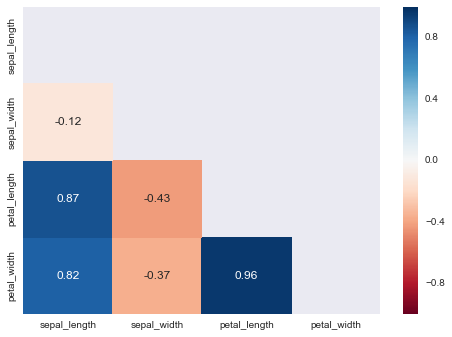

In [19]:
corr = iris.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = 1
sns.heatmap(corr, mask=mask, annot=True, cmap='RdBu',);

## Regresión logística multinomial o regresión Softmax

Ahora vamos a generalizar la regresión logística a casos donde tenenemos más de 2 clases que clasificar. Una forma de hacer esto es mediante la llamada regresión logística multinomial, que también se la conoce como regresión softmax.

Para cada categoría $j$ de un total de $k$ categoría tenemos que

$$\lambda_j = \alpha_j + \beta_j X$$

Siendo que la probabilidad de obtener la categoria $j$ es:

$$P(y=j|\mathbf{x}) = \frac{e^{\lambda_j}}{\sum_{k=1}^k e^{\lambda_k}} $$

Esta ecuación se conoce como softmax, la cual se reduce a ecuacion logística para k=2.

### Ejemplo Iris

In [20]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes()
from plot_post import plot_post
import pandas as pd  # importar pandas
import theano.tensor as tt

In [21]:
iris = sns.load_dataset("iris")
y_2 = pd.Categorical(iris['species']).labels
x_n = iris.columns[:-1]
x_2 = iris[x_n].values
#x_2 = (x_2 - x_2.mean(axis=0))/x_2.std(axis=0)
#y_2 = (np.arange(np.max(y_2) + 1) == y_2[:, None]).astype(float)

In [22]:
with pm.Model() as modelo_s:
    alfa = pm.Normal('alfa', mu=0, sd=10, shape=3)
    beta = pm.Normal('beta', mu=0, sd=10, shape=(4,3))

    mu = alfa + pm.dot(x_2, beta)
    p = pm.Deterministic('p', tt.nnet.softmax(mu))

    yl = pm.Categorical('yl', p=p, observed=y_2)
    #yl = pm.Multinomial('yl', n=1, p=p.T, observed=y_2)
    #start = pm.find_MAP()
    #step = pm.NUTS(scaling=start)
    step = pm.Metropolis()
    trace_s = pm.sample(5000, step)

 [-----------------100%-----------------] 5000 of 5000 complete in 3.3 sec

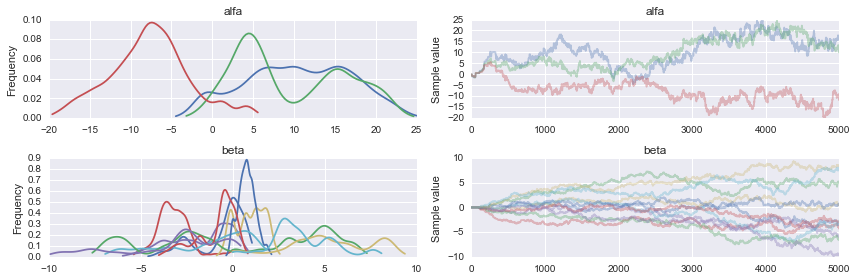

In [23]:
cadena_s = trace_s[::]
varnames = ['alfa', 'beta']
pm.traceplot(cadena_s, varnames);

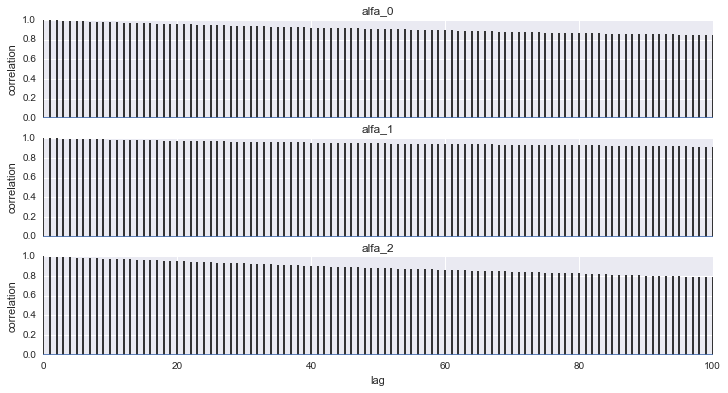

In [24]:
pm.autocorrplot(cadena_s, varnames=['alfa']);

In [25]:
data_pred = cadena_s['alfa'].mean(axis=0) + np.dot(x_2, cadena_s['beta'].mean(axis=0))
y_pred = []
for point in data_pred:
    y_pred.append(np.exp(point)/np.sum(np.exp(point), axis=0))
np.sum(y_2 == np.argmax(y_pred, axis=1))/len(y_2)

0.97999999999999998

In [26]:
np.argmax(y_pred, axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

### Ejemplo MNIST

In [27]:
from sklearn import linear_model, datasets

# import some data to play with
digits = datasets.load_digits()
X = digits.data  # we only take the first two features.
Y = digits.target

logreg = linear_model.LogisticRegression(C=1e5)

# we create an instance of Neighbours Classifier and fit the data.
logreg.fit(X, Y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
Z = logreg.predict(X)

In [28]:
np.sum(digits.target==Z)/len(digits.target)

0.99888703394546463

In [29]:
with pm.Model() as modelo_d:
    alfa = pm.Normal('alfa', mu=0, sd=10, shape=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=(64,10))

    mu = alfa + pm.dot(X, beta)
    p = pm.Deterministic('p', tt.nnet.softmax(mu))

    yl = pm.Categorical('yl', p=p, observed=Y)
    #yl = pm.Multinomial('yl', n=1, p=p.T, observed=y_2)
    #start = pm.find_MAP()
    #step = pm.NUTS(scaling=start)
    step = pm.Metropolis()
    trace_d = pm.sample(5000, step)

 [-----------------100%-----------------] 5000 of 5000 complete in 28.1 sec

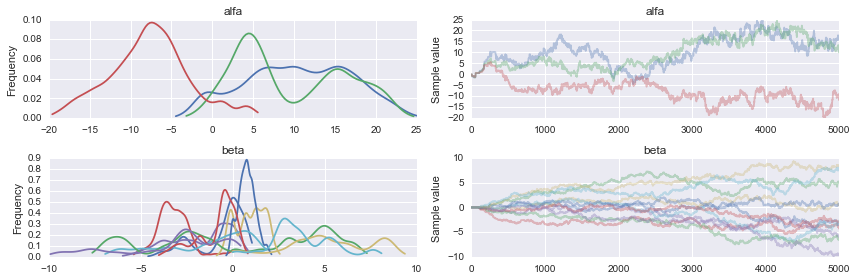

In [30]:
cadena_d = trace_d[2500::]
varnames = ['alfa', 'beta']
pm.traceplot(cadena_s, varnames);

In [31]:
data_pred = cadena_d['alfa'].mean(axis=0) + np.dot(X, cadena_d['beta'].mean(axis=0))
Y_pred = []
for point in data_pred:
    Y_pred.append(np.exp(point)/np.sum(np.exp(point), axis=0))
np.sum(Y == np.argmax(Y_pred, axis=1))/len(Y)

0.96828046744574292

In [32]:
np.sum(np.argmax(Y_pred, axis=1)==Z)/len(digits.target)

0.96828046744574292

(1797, 64)


(1, array([  0.,   0.,   0.,   0.,  12.,   5.,   0.,   0.,   0.,   0.,   0.,
          2.,  16.,  12.,   0.,   0.,   0.,   0.,   1.,  12.,  16.,  11.,
          0.,   0.,   0.,   2.,  12.,  16.,  16.,  10.,   0.,   0.,   0.,
          6.,  11.,   5.,  15.,   6.,   0.,   0.,   0.,   0.,   0.,   1.,
         16.,   9.,   0.,   0.,   0.,   0.,   0.,   2.,  16.,  11.,   0.,
          0.,   0.,   0.,   0.,   3.,  16.,   8.,   0.,   0.]))

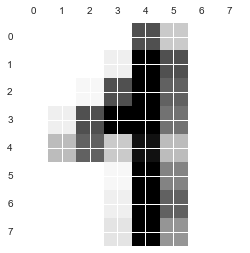

In [33]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape)
test = 42
plt.matshow(digits.images[test])
digits.target[test], digits.data[test]

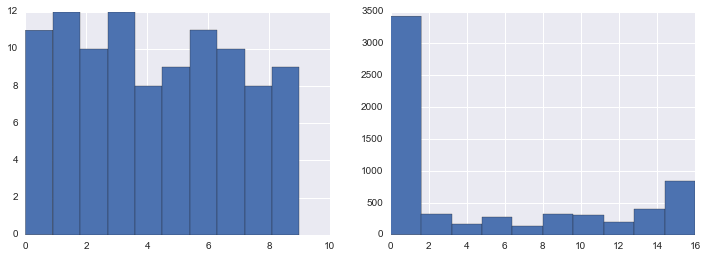

In [34]:
y_d = digits.target[:100]
x_d = digits.data[:100]
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(y_d)
plt.subplot(1,2,2)
plt.hist(x_d.ravel());

In [35]:
import sys, IPython, scipy, matplotlib, platform
print("Esta notebook fue creada en una computadora %s corriendo %s y usando:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\nPandas %s" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__, pd.__version__))

Esta notebook fue creada en una computadora x86_64 corriendo debian stretch/sid y usando:
Python 3.5.1
IPython 4.0.3
PyMC3 3.0
NumPy 1.11.0
SciPy 0.17.0
Matplotlib 1.5.1
Seaborn 0.7.0
Pandas 0.18.1
